In [1]:
%%time
import sys
#!{sys.executable} -m pip install -r requirements.txt


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [2]:
%%time
import boto3
import datetime
import math 
import matplotlib.pyplot as plt   
from matplotlib import pyplot
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import sagemaker
import seaborn  
import sagemaker
from sklearn.model_selection import train_test_split
from sklearn.metrics import * 
from xgboost import XGBClassifier

CPU times: user 1.6 s, sys: 83.9 ms, total: 1.68 s
Wall time: 1.68 s


In [3]:
%%time

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print(f'Bucket {bucket} in region {region}')

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 208 ms, sys: 12.5 ms, total: 220 ms
Wall time: 2.25 s


In [4]:
%%time
filename='from_databrew.parquet.snappy' 
s3 = boto3.resource('s3', region_name=region)

#s3.Bucket(bucket).download_file(
# 'normalize-3-snappy-parquet/normalize-3_02Dec2020_1606903905135/normalize-3_02Dec2020_1606903905135_part00000.parquet.snappy',
#    filename)
table = pq.read_table(filename)
df = table.to_pandas()    
    
print('Length', len(df))
df

Length 6362620
CPU times: user 1.15 s, sys: 673 ms, total: 1.82 s
Wall time: 1.67 s


,isFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount_nml,oldBalanceOrigin_nml,newBalanceOrigin_nml,oldBalanceDestination_nml,newBalanceDestination_nml
0,0,1.0,0,0,0,1,0,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411
1,0,1.0,0,0,0,1,0,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411
2,1,1.0,0,0,0,0,1,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411
3,1,1.0,0,1,0,0,0,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411
4,0,1.0,0,0,0,1,0,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,1,23.0,0,1,0,0,0,0.264665,-0.171108,-0.292442,-0.323814,-0.240959
6362616,1,23.0,0,0,0,0,1,10.153952,1.896491,-0.292442,-0.323814,-0.333411
6362617,1,23.0,0,1,0,0,0,10.153952,1.896491,-0.292442,-0.303665,1.403027
6362618,1,23.0,0,0,0,0,1,1.109765,0.005581,-0.292442,-0.323814,-0.333411


In [5]:
target_col='isFraud'

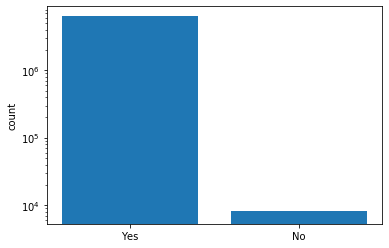

In [6]:
def plot_positive_negative_counts(df, target_col):
    val_counts=df['isFraud'].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale='log')
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,'isFraud')

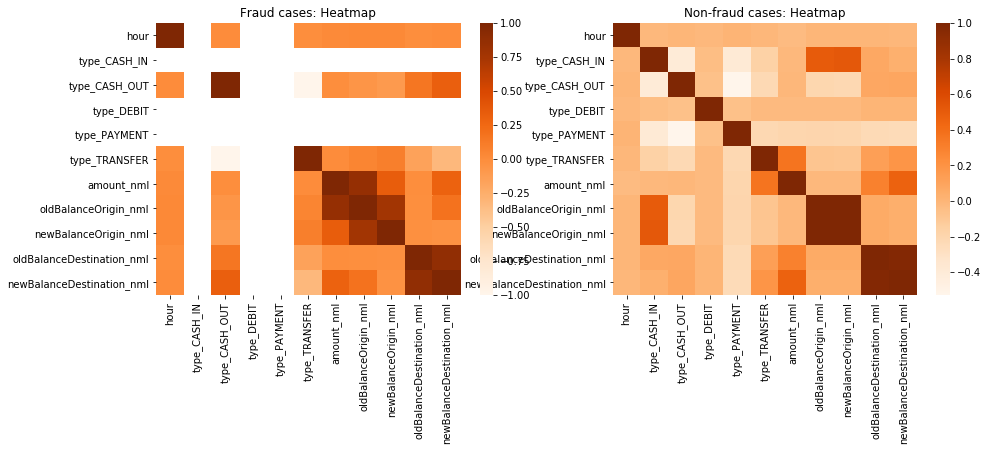

In [7]:
fig, axes = plt.subplots( 1,2, figsize=(15,5))

def heatmap(fraud_cases):
    lbl = 'Fraud' if  fraud_cases else 'Non-fraud'
    # Coerced to int, below
    axes[1-fraud_cases].set_title(f'{lbl} cases: Heatmap')
    seaborn.heatmap(df.query(f'isFraud == {fraud_cases}').drop(['isFraud'], 1).corr(),  cmap='Oranges', ax=axes[1-fraud_cases])

heatmap(True)
heatmap(False)

plt.show()

In [8]:
HOURS_IN_DAY  =24

frauds_by_hour = []
non_frauds_by_hour = []
hourwise_items = []
for hour in range(HOURS_IN_DAY):
    non_fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 0)]
    non_fraud_sum_in_hour = len(non_fraud_in_hour)
    fraud_in_hour = df[(df['hour'] == hour) & (df['isFraud'] == 1)]
    fraud_sum_in_hour = len(fraud_in_hour)
    non_frauds_by_hour.append(non_fraud_sum_in_hour)
    frauds_by_hour.append(fraud_sum_in_hour)
    hourwise_items.append(non_fraud_sum_in_hour+fraud_sum_in_hour)

fig, ax = plt.subplots(figsize=(11, 7))
 
fr_non_fraud = ax.plot(np.multiply(np.divide(frauds_by_hour,hourwise_items), 100), label='Fraud percentage by hour')
plt.xticks(np.arange(24))
legend = ax.legend(loc='upper left' )
 

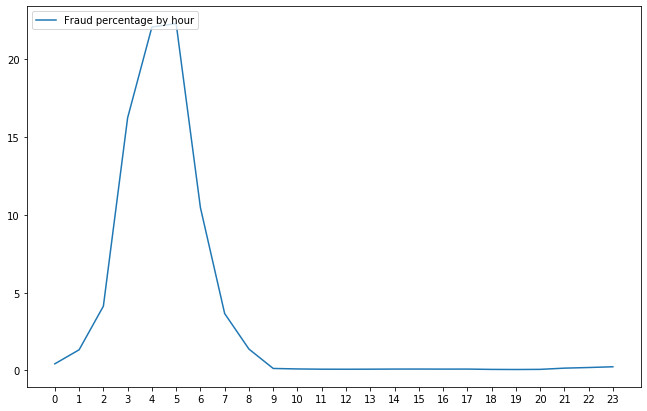

In [8]:
series = pd.Series(np.select([(df['hour'] >=2) & (df['hour'] <=6)], [1], 0))
df['peakHours']=series

del df['hour']

In [10]:
dataset = df.to_numpy()
X = dataset[:,1:]
y = dataset[:,0]

In [11]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [12]:
%%time
print(f'Start fit at {str(datetime.datetime.now())[:-7]}Z')
model = XGBClassifier( objective='binary:logistic', scale_pos_weight=5 )
model.fit(X, y, verbose=True)

Start fit at 2020-12-02 11:16:02Z
[11:16:07] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
CPU times: user 43min 3s, sys: 23.4 s, total: 43min 27s
Wall time: 11min 18s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='approx', validate_parameters=1, verbosity=None)

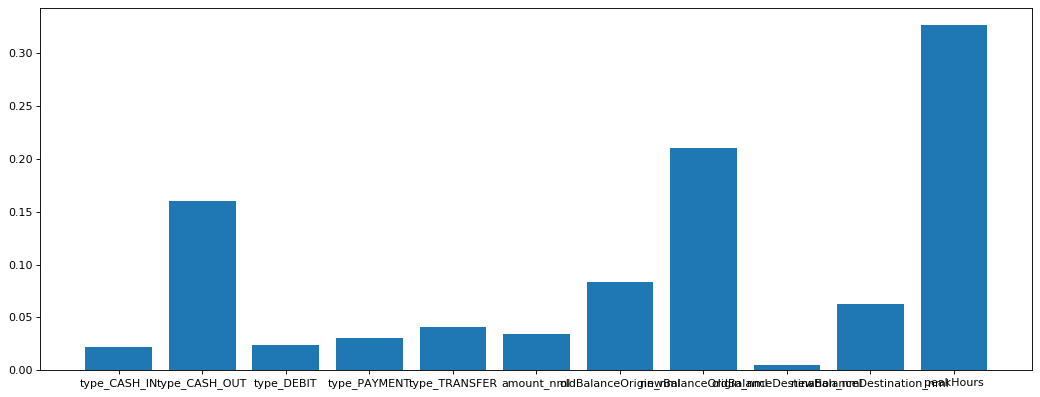

CPU times: user 550 ms, sys: 23.8 ms, total: 574 ms
Wall time: 403 ms


In [13]:
%%time

fields_short_names = [s.replace('balance', 'Bal') for s in df.columns[1:]]
 
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_, tick_label=fields_short_names)
        
pyplot.show()

accuracy_score: 99.98%
f1_score: 91.22%
precision_score: 86.64%
recall_score: 96.32%
balanced_accuracy_score: 98.15%


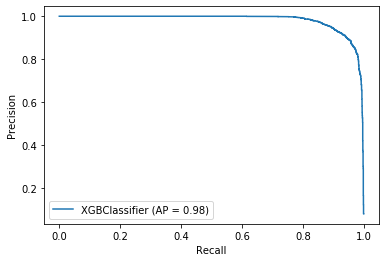

In [14]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# Not auc, roc_auc_score
functions = [accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score ]
for f in functions:
  print("%s: %.2f%%" % (f.__name__, f(y_test, predictions) * 100.0))

plot_precision_recall_curve(model, X_test, y_test)  